In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
from tqdm import tqdm
import datetime
import proplot as plot
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name

ctrl_U,ctrl_V = origin_path+'ctl/azim_U10_0-144hr.nc',origin_path+'ctl/azim_V10_0-144hr.nc'
lwcrf_U,lwcrf_V = origin_path+'lwcrf/azim_U10_36-144hr.nc',origin_path+'lwcrf/azim_V10_36-144hr.nc'
ncrf_36h_U,ncrf_36h_V = origin_path+'ncrf_36h/azim_U10_36-144hr.nc',origin_path+'ncrf_36h/azim_V10_36-144hr.nc'
ncrf_60h_U,ncrf_60h_V = origin_path+'ncrf_60h/azim_U10_60-144hr.nc',origin_path+'ncrf_60h/azim_V10_60-144hr.nc'
ncrf_96h_U,ncrf_96h_V = origin_path+'ncrf_96h/azim_U10_96-144hr.nc',origin_path+'ncrf_96h/azim_V10_96-144hr.nc'

ctrl_dict = read_some_azimuth_fields(fileloc=[ctrl_U,ctrl_V],fieldname=['U','V'])
lwcrf_dict = read_some_azimuth_fields(fileloc=[lwcrf_U,lwcrf_V],fieldname=['U','V'])
ncrf_36h_dict = read_some_azimuth_fields(fileloc=[ncrf_36h_U,ncrf_36h_V],fieldname=['U','V'])
ncrf_60h_dict = read_some_azimuth_fields(fileloc=[ncrf_60h_U,ncrf_60h_V],fieldname=['U','V'])
ncrf_96h_dict = read_some_azimuth_fields(fileloc=[ncrf_96h_U,ncrf_96h_V],fieldname=['U','V'])

In [3]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

i500 = nearest_index(ctrl_dict['U'].radius,500)
def ruppert_vtmax_calc(datadict=None,outer_limit=i500):
    d2r = np.pi/180
    try:
        wdir = (np.arctan(datadict['V'].V10/datadict['U'].U10)/d2r).values
    except:
        print('Cannot find wind field arrays!')
    loc_neg = (datadict['U'].U10<0)
    wdir[loc_neg] += 180
    wspd = np.sqrt(datadict['U'].U10**2+datadict['V'].V10**2).values
    az = datadict['U'].azmiuth.values
    azt = np.moveaxis(np.tile(az,(datadict['U'].U10.shape[0],1,433,1)),-1,-2)
    Urad = wspd*np.cos((wdir-azt)*d2r)
    Vtan = wspd*np.sin((wdir-azt)*d2r)
    Vtan_max = np.max(np.mean(Vtan[:,0,:,:i500],axis=1),axis=1)
    return Urad,Vtan,Vtan_max

In [4]:
_,_,ctrlVtanmax = ruppert_vtmax_calc(datadict=ctrl_dict,outer_limit=i500)
_,_,lwcrfVtanmax = ruppert_vtmax_calc(datadict=lwcrf_dict,outer_limit=i500)
_,_,ncrf_36hVtanmax = ruppert_vtmax_calc(datadict=ncrf_36h_dict,outer_limit=i500)
_,_,ncrf_60hVtanmax = ruppert_vtmax_calc(datadict=ncrf_60h_dict,outer_limit=i500)
_,_,ncrf_96hVtanmax = ruppert_vtmax_calc(datadict=ncrf_96h_dict,outer_limit=i500)

#### Intensification Rate

In [5]:
import pandas as pd
from scipy.signal import find_peaks
from scipy.ndimage.filters import uniform_filter1d
from scipy.ndimage import gaussian_filter
wdw=3
# I. Smooth Vtanmax (3 hour rolling window); II. Time difference
#####################################################################################################################################################
smoovtanmax_dict = {'ctrl':uniform_filter1d(ctrlVtanmax,wdw),'lwcrf':uniform_filter1d(lwcrfVtanmax,wdw),'ncrf36':uniform_filter1d(ncrf_36hVtanmax,wdw),\
                    'ncrf60':uniform_filter1d(ncrf_60hVtanmax,wdw),'ncrf96':uniform_filter1d(ncrf_96hVtanmax,wdw)}
testctrl = pd.DataFrame({'CTRL': np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24)})
test_lwcrf = pd.DataFrame({'lwcrf':np.gradient(smoovtanmax_dict['lwcrf'],lwcrf_dict['U'].time/24+36/24)})
test_ncrf36 = pd.DataFrame({'NCRF_36h':np.gradient(smoovtanmax_dict['ncrf36'],ncrf_36h_dict['U'].time/24+36/24)})
test_ncrf60 = pd.DataFrame({'NCRF_60h':np.gradient(smoovtanmax_dict['ncrf60'],ncrf_60h_dict['U'].time/24+60/24)})

# Target temporal period
#####################################################################################################################################################
time2_ctrl,time45_ctrl = nearest_index(ctrl_dict['U'].time/24, 2),nearest_index(ctrl_dict['U'].time/24, 4.5)
time2_ncrf36,time45_ncrf36 = nearest_index(ncrf_36h_dict['U'].time/24+36/24, 2),nearest_index(ncrf_36h_dict['U'].time/24+36/24, 4.5)
time2_ncrf60,time45_ncrf60 = nearest_index(ncrf_60h_dict['U'].time/24+60/24, 2),nearest_index(ncrf_60h_dict['U'].time/24+60/24, 4.5)

# Rolling standard deviation (i.e., find large changes in inten. rate time series)
#####################################################################################################################################################
intest_ctrl = gaussian_filter(np.gradient(testctrl['CTRL'].rolling(6).std(ddof=1),ctrl_dict['U'].time/24),0.8)[time2_ctrl:time45_ctrl]
intest_ncrf36 = gaussian_filter(np.gradient(test_ncrf36['NCRF_36h'].rolling(6).std(ddof=1),ncrf_36h_dict['U'].time/24+36/24),0.8)[time2_ncrf36:time45_ncrf36]
intest_ncrf60 = gaussian_filter(np.gradient(test_ncrf60['NCRF_60h'].rolling(6).std(ddof=1),ncrf_60h_dict['U'].time/24+60/24),0.8)[time2_ncrf60:time45_ncrf60]

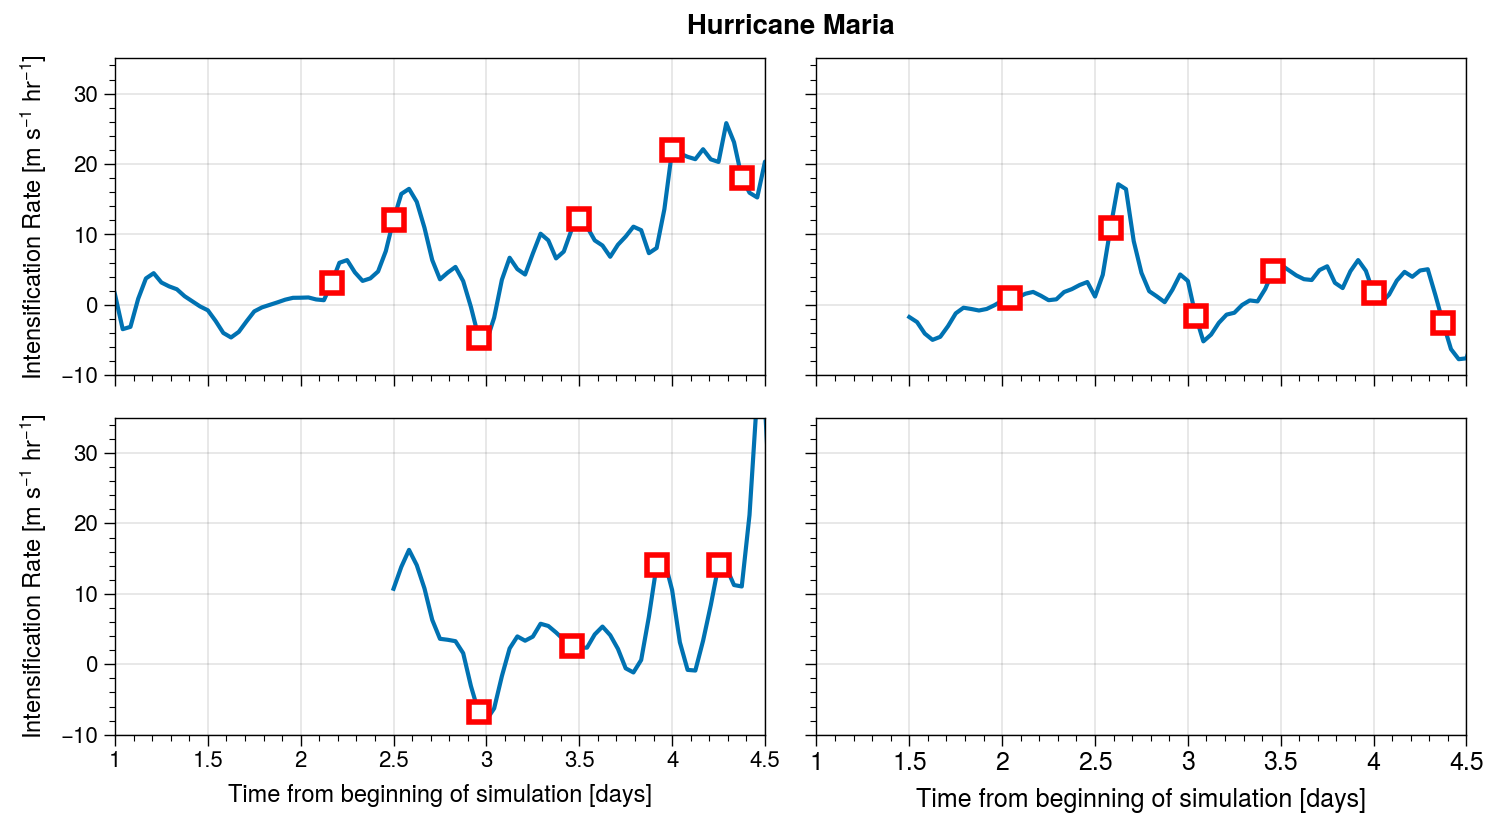

In [6]:
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.25,refaspect=2.051,span=False)
axs[0].plot(ctrl_dict['U'].time/24,np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24),label='CTRL')
axs[0].plot((ctrl_dict['U'].time[time2_ctrl:time45_ctrl]/24)[find_peaks(intest_ctrl,distance=6)[0]],
         np.gradient(smoovtanmax_dict['ctrl'],ctrl_dict['U'].time/24)[time2_ctrl:time45_ctrl][find_peaks(intest_ctrl,distance=6)[0]],
         lw=0,marker='s',ms=7,mec='r',mfc='w',mew=2)
#ylim=[-10,25],
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)

axs[1].plot(ncrf_36h_dict['U'].time/24+36/24,np.gradient(smoovtanmax_dict['ncrf36'],ncrf_36h_dict['U'].time/24+36/24),label='NCRF_36H')
axs[1].plot((ncrf_36h_dict['U'].time[time2_ncrf36:time45_ncrf36]/24+36/24)[find_peaks(intest_ncrf36,distance=6)[0]],
         np.gradient(smoovtanmax_dict['ncrf36'],ncrf_36h_dict['U'].time/24+36/24)[time2_ncrf36:time45_ncrf36][find_peaks(intest_ncrf36,distance=6)[0]],
         lw=0,marker='s',ms=7,mec='r',mfc='w',mew=2)
#ylim=[-10,25],
axs[1].yaxis.label.set_size(8.5)
axs[1].xaxis.label.set_size(8.5)
axs[1].tick_params(axis='both', which='major', labelsize=8)

axs[2].plot(ncrf_60h_dict['U'].time/24+60/24,np.gradient(smoovtanmax_dict['ncrf60'],ncrf_60h_dict['U'].time/24+60/24),label='NCRF_36H')
axs[2].plot((ncrf_60h_dict['U'].time[time2_ncrf60:time45_ncrf60]/24+60/24)[find_peaks(intest_ncrf60,distance=6)[0]],
         np.gradient(smoovtanmax_dict['ncrf60'],ncrf_60h_dict['U'].time/24+60/24)[time2_ncrf60:time45_ncrf60][find_peaks(intest_ncrf60,distance=6)[0]],
         lw=0,marker='s',ms=7,mec='r',mfc='w',mew=2)
#ylim=[-10,25],
axs[2].yaxis.label.set_size(8.5)
axs[2].xaxis.label.set_size(8.5)
axs[2].tick_params(axis='both', which='major', labelsize=8)

axs.format(ylim=[-10,35],xlim=[1,4.5],xlabel='Time from beginning of simulation [days]',\
              ylabel='Intensification Rate [m s$^{-1}$ hr$^{-1}$]',suptitle='Hurricane Maria')
plt.show()

##### Save to pickle

In [7]:
import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None
save_to_pickle(loc='./output/peaks_v1/ctrl-peaks-02_45',var=find_peaks(intest_ctrl,distance=6)[0])
save_to_pickle(loc='./output/peaks_v1/ncrf36-peaks-02_45',var=find_peaks(intest_ncrf36,distance=6)[0])
save_to_pickle(loc='./output/peaks_v1/ncrf60-peaks-02_45',var=find_peaks(intest_ncrf60,distance=6)[0])

#### Choose peaks

In [8]:
ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_PW_0-144hr.nc',origin_path+'ctl/azim_RTHRATLWC_0-144hr.nc',
                                                 origin_path+'ctl/azim_RTHRATLW_0-144hr.nc'],
                                        fieldname=['PW','RATLWC','RATLW'])
ncrf36var_dict = read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_PW_36-144hr.nc',
                                                  origin_path+'ncrf_36h/azim_RTHRATLW_36-144hr.nc'],fieldname=['PW','RATLW'])
ncrf60var_dict = read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_PW_60-144hr.nc',
                                                  origin_path+'ncrf_60h/azim_RTHRATLW_60-144hr.nc'],fieldname=['PW','RATLW'])

In [13]:
indx = 3
target_ctrl,target_ncrf36,target_ncrf60 = time2_ctrl+find_peaks(intest_ctrl,distance=6)[0][indx],\
time2_ncrf36+find_peaks(intest_ncrf36,distance=6)[0][indx],\
time2_ncrf60+find_peaks(intest_ncrf60,distance=6)[0][indx-2]

In [14]:
pw_extct_p4_ctrl = ctrlvar_dict['PW']['PW'][target_ctrl-1-12:target_ctrl-1,0,:,:]
pw_extct_p4_ncrf36 = ncrf36var_dict['PW']['PW'][target_ncrf36-1-12:target_ncrf36-1,0,:,:]
pw_extct_p4_ncrf60 = ncrf60var_dict['PW']['PW'][target_ncrf60-1-12:target_ncrf60-1,0,:,:]

In [15]:
from copy import deepcopy

pw_extct_p4_ctrl = ctrlvar_dict['PW']['PW'][target_ctrl-1-12:target_ctrl-1,0,:,:]
pw_extct_p4_ncrf36 = ncrf36var_dict['PW']['PW'][target_ncrf36-1-12:target_ncrf36-1,0,:,:]
pw_extct_p4_ncrf60 = ncrf60var_dict['PW']['PW'][target_ncrf60-1-12:target_ncrf60-1,0,:,:]
PWper_ctrl,PWper_ncrf36,PWper_ncrf60 = [],[],[]
for indx in range(len(pw_extct_p4_ctrl[:,0,0])):
    temp = pw_extct_p4_ctrl[indx,:,:i500]-np.mean(np.mean(pw_extct_p4_ctrl[indx,:,:i500],axis=1),axis=0)
    PWper_ctrl.append((temp-np.mean(temp))/np.std(temp))
del temp

for indx in range(len(pw_extct_p4_ncrf36[:,0,0])):
    temp = pw_extct_p4_ncrf36[indx,:,:i500]-np.mean(np.mean(pw_extct_p4_ncrf36[indx,:,:i500],axis=1),axis=0)
    PWper_ncrf36.append((temp-np.mean(temp))/np.std(temp))
del temp

for indx in range(len(pw_extct_p4_ncrf60[:,0,0])):
    temp = pw_extct_p4_ncrf60[indx,:,:i500]-np.mean(np.mean(pw_extct_p4_ncrf60[indx,:,:i500],axis=1),axis=0)
    PWper_ncrf60.append((temp-np.mean(temp))/np.std(temp))
del temp

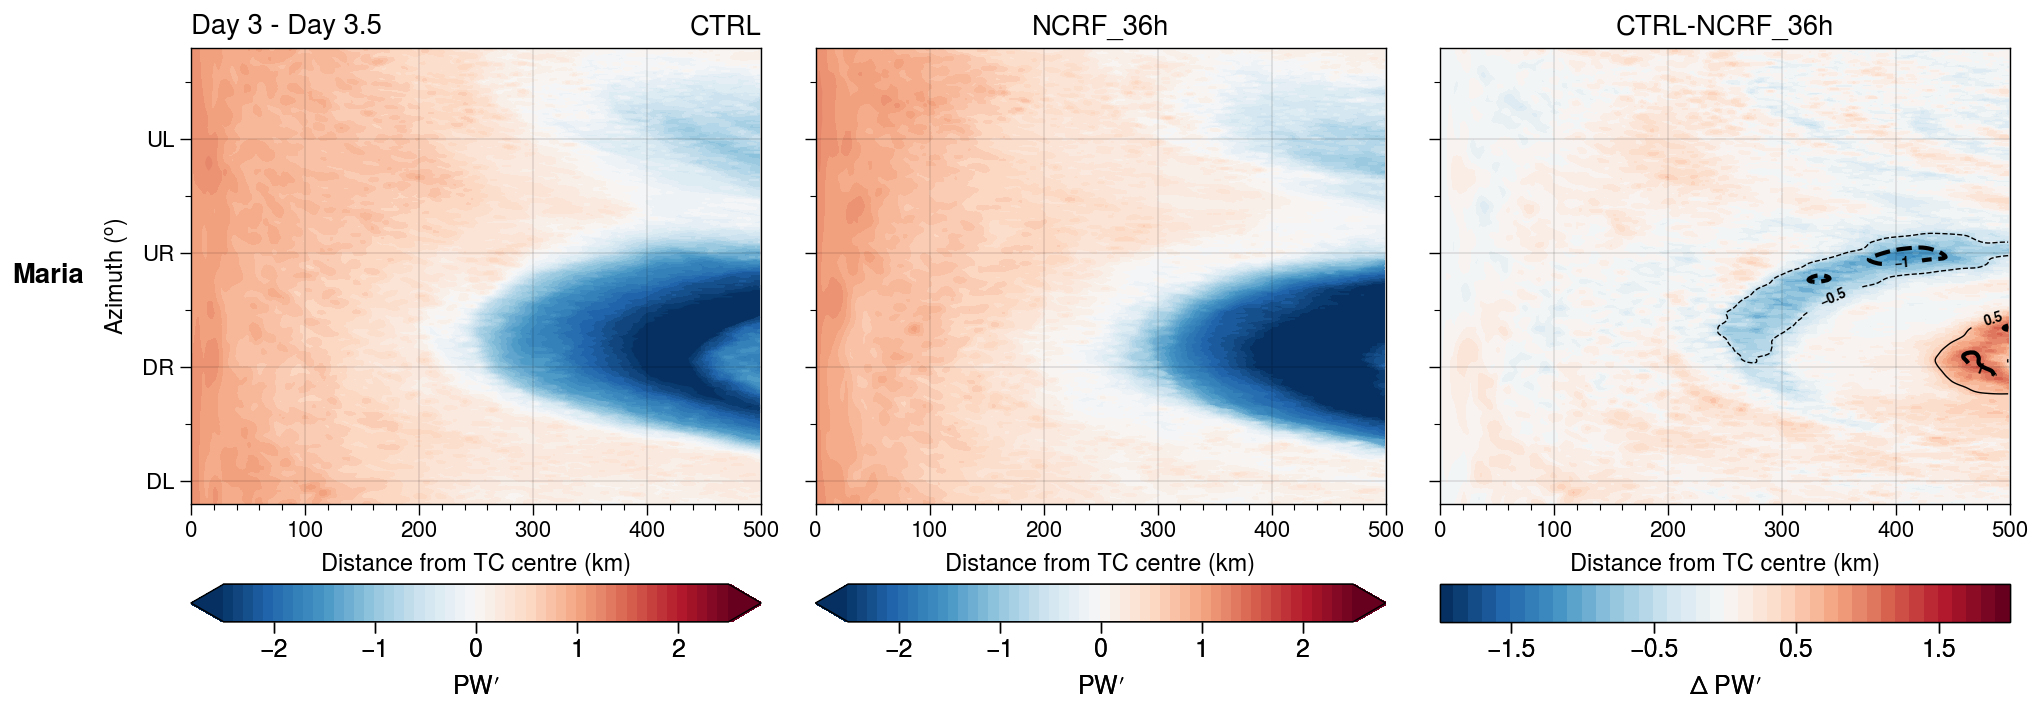

In [18]:
from skimage import filters
import matplotlib.ticker as mticker
PWper_ctrlcmp = np.nanmean(np.asarray(PWper_ctrl),axis=0)
PWper_ncrf36cmp = np.nanmean(np.asarray(PWper_ncrf36),axis=0)
#img=plt.pcolormesh(dataPW.radius[:i500],dataPW.azmiuth,\
#                   PWper_highcmp,cmap='RdBu_r',vmin=-3,vmax=3)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Day 3 - Day 3.5',rtitle='CTRL')
img=axs[1].contourf(ncrf36var_dict['PW'].radius[:i500],ncrf36var_dict['PW'].azmiuth,PWper_ncrf36cmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='NCRF_36h')
img=axs[2].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp-PWper_ncrf36cmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ncrf36cmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ncrf36cmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ PW$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='CTRL-NCRF_36h')
axs.format(yticks=[18.22,108.22,198.22,288.22],yticklabels=['DL','DR','UR','UL'],leftlabels='Maria')
for axisobj in axs:
    axisobj.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

/work/08350/tg876493/stampede2/gpu_env/fred_workenv/lib/python3.8/site-packages/proplot/axes/plot.py:3496: UserWarning: No contour levels were found within the data range.
  obj = method(self, *args, **kwargs)
/work/08350/tg876493/stampede2/gpu_env/fred_workenv/lib/python3.8/site-packages/proplot/axes/plot.py:3496: UserWarning: No contour levels were found within the data range.
  obj = method(self, *args, **kwargs)


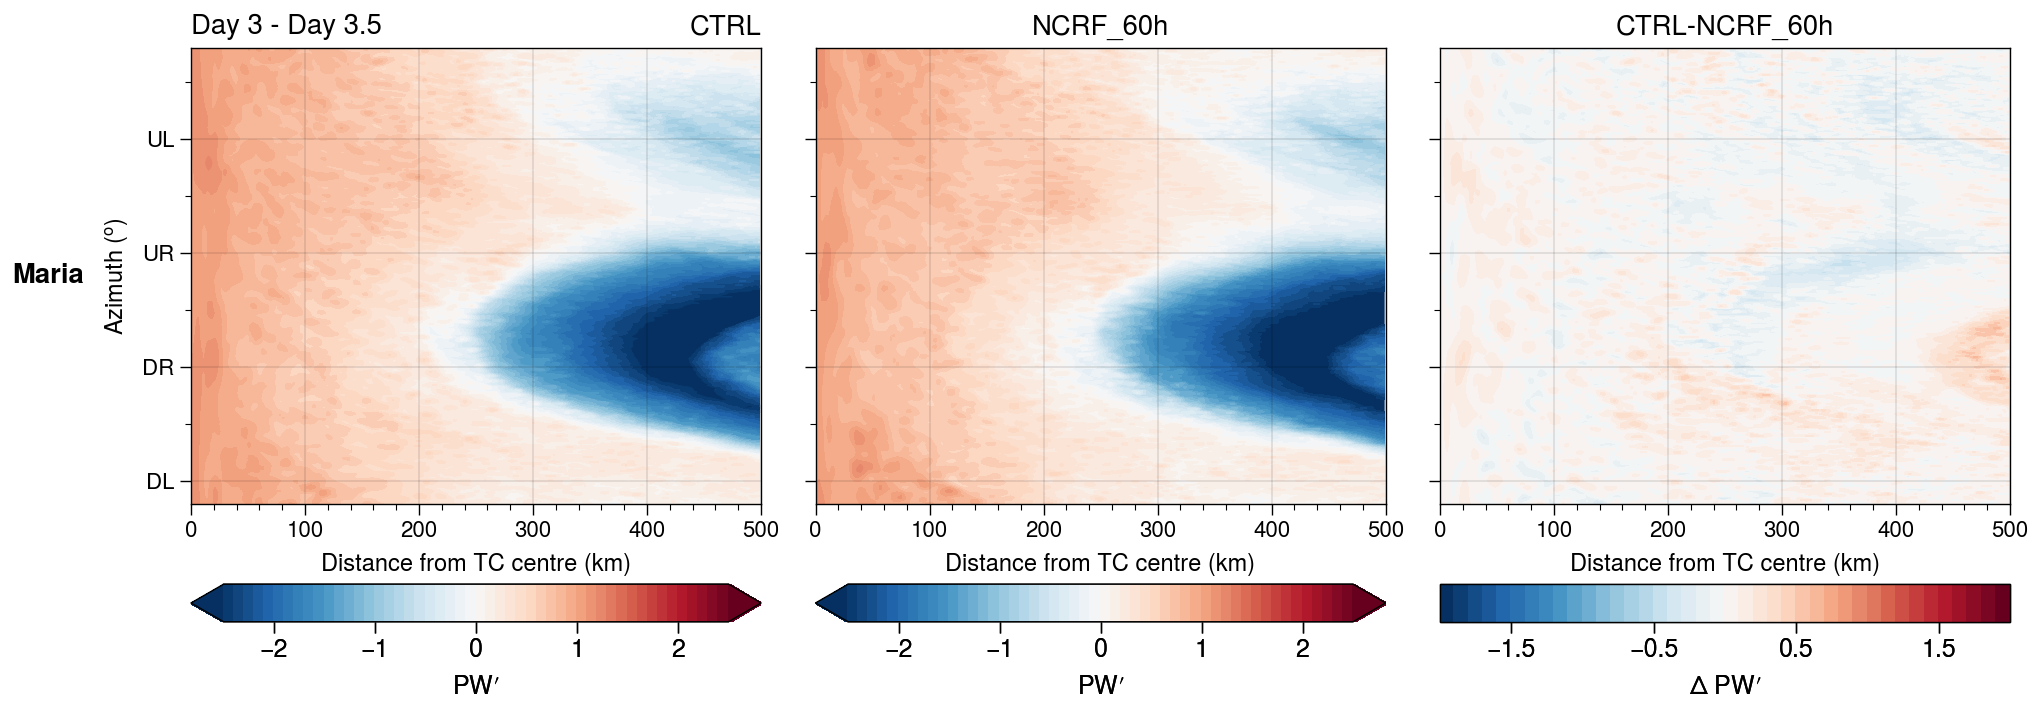

In [19]:
PWper_ncrf60cmp = np.nanmean(np.asarray(PWper_ncrf60),axis=0)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',ltitle='Day 3 - Day 3.5',rtitle='CTRL')
img=axs[1].contourf(ncrf36var_dict['PW'].radius[:i500],ncrf60var_dict['PW'].azmiuth,PWper_ncrf60cmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='NCRF_60h')
img=axs[2].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp-PWper_ncrf60cmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ncrf60cmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ncrf60cmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ PW$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='CTRL-NCRF_60h')
axs.format(yticks=[18.22,108.22,198.22,288.22],yticklabels=['DL','DR','UR','UL'],leftlabels='Maria')
for axisobj in axs:
    axisobj.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

#### What is different about the period before sudden intensification?

In [20]:
pw_ALL_p4_ctrl = ctrlvar_dict['PW']['PW'][0:target_ctrl-1,0,:,:]
pw_ALL_p4_ncrf36 = ncrf36var_dict['PW']['PW'][0:target_ncrf36-1,0,:,:]
pw_ALL_p4_ncrf60 = ncrf60var_dict['PW']['PW'][0:target_ncrf60-1,0,:,:]

PWper_ALL_ctrl,PWper_ALL_ncrf36,PWper_ALL_ncrf60 = [],[],[]
for indx in range(len(pw_ALL_p4_ctrl[:,0,0])):
    temp = pw_ALL_p4_ctrl[indx,:,:i500]-np.mean(np.mean(pw_ALL_p4_ctrl[indx,:,:i500],axis=1),axis=0)
    PWper_ALL_ctrl.append((temp-np.mean(temp))/np.std(temp))
del temp

for indx in range(len(pw_ALL_p4_ncrf36[:,0,0])):
    temp = pw_ALL_p4_ncrf36[indx,:,:i500]-np.mean(np.mean(pw_ALL_p4_ncrf36[indx,:,:i500],axis=1),axis=0)
    PWper_ALL_ncrf36.append((temp-np.mean(temp))/np.std(temp))
del temp

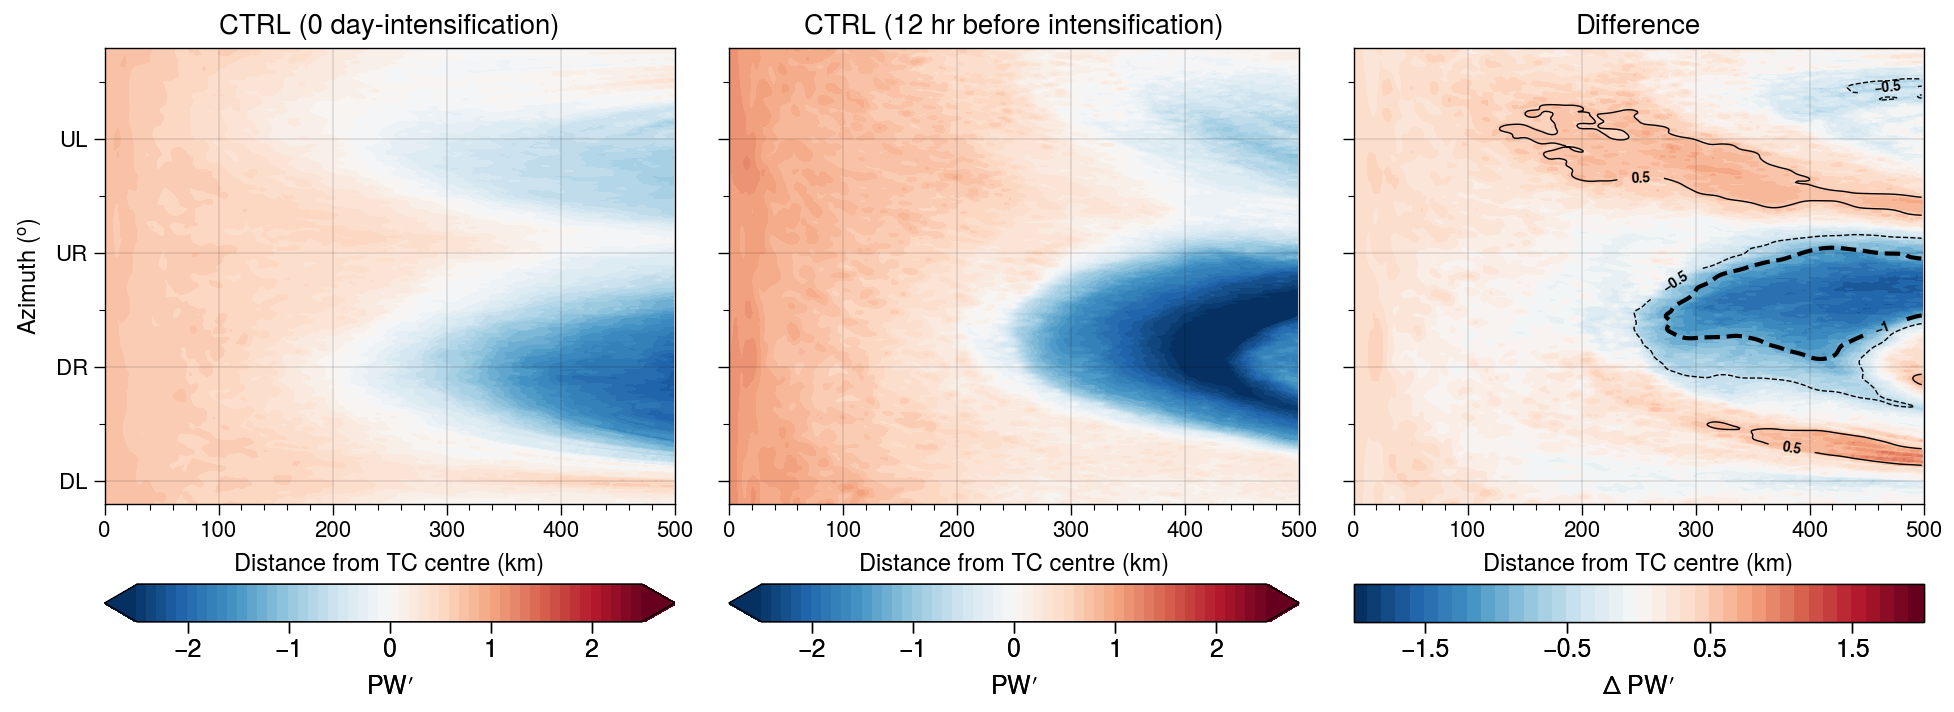

In [21]:
PWper_ctrlcmp = np.nanmean(np.asarray(PWper_ctrl),axis=0)
PWper_ALL_ctrlcmp = np.nanmean(np.asarray(PWper_ALL_ctrl),axis=0)
#img=plt.pcolormesh(dataPW.radius[:i500],dataPW.azmiuth,\
#                   PWper_highcmp,cmap='RdBu_r',vmin=-3,vmax=3)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ALL_ctrlcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='CTRL (0 day-intensification)')
img=axs[1].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='CTRL (12 hr before intensification)')
img=axs[2].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ctrlcmp-PWper_ALL_ctrlcmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ALL_ctrlcmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ctrlcmp-PWper_ALL_ctrlcmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ PW$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='Difference')
axs.format(yticks=[18.22,108.22,198.22,288.22],yticklabels=['DL','DR','UR','UL'])
for axisobj in axs:
    axisobj.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()

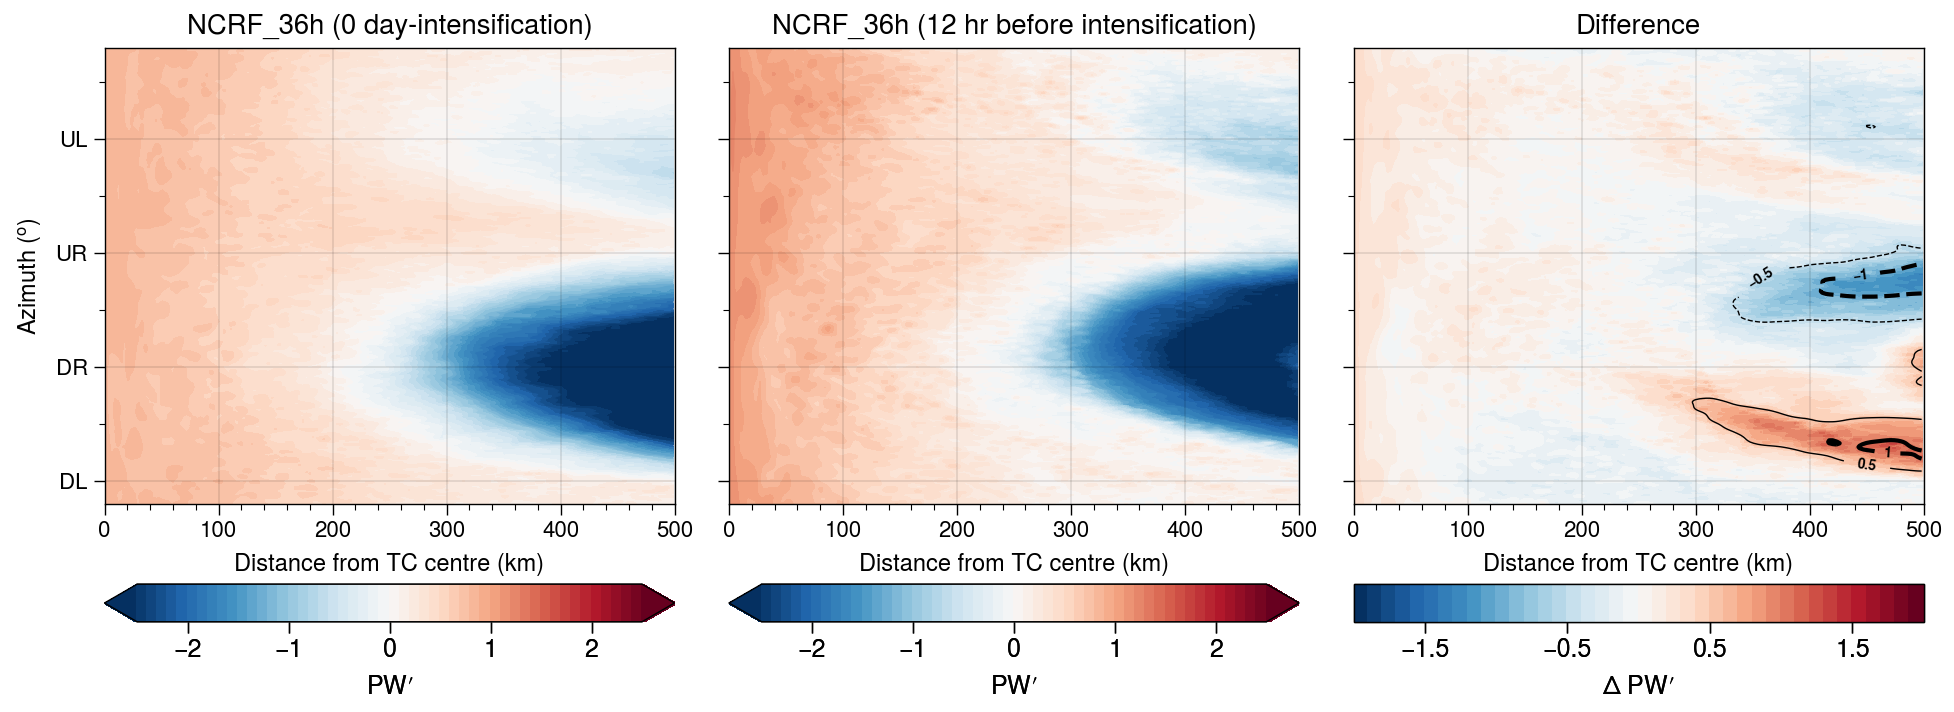

In [22]:
PWper_ncrf36cmp = np.nanmean(np.asarray(PWper_ncrf36),axis=0)
PWper_ALL_ncrf36cmp = np.nanmean(np.asarray(PWper_ALL_ncrf36),axis=0)
#img=plt.pcolormesh(dataPW.radius[:i500],dataPW.azmiuth,\
#                   PWper_highcmp,cmap='RdBu_r',vmin=-3,vmax=3)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.85,refaspect=1.251,span=False)
img=axs[0].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ALL_ncrf36cmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[0].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[0].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='NCRF_36h (0 day-intensification)')
img=axs[1].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ncrf36cmp,cmap='RdBu_r',
                    levels=np.linspace(-2.5,2.5,51),extend='both')
axs[1].colorbar(img,ticks=[-2,-1,0,1,2],label=r'PW$\prime$',loc='b')
axs[1].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',title='NCRF_36h (12 hr before intensification)')
img=axs[2].contourf(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,PWper_ncrf36cmp-PWper_ALL_ncrf36cmp,cmap='RdBu_r',
                    levels=np.linspace(-2,2,41))
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ncrf36cmp-PWper_ALL_ncrf36cmp,2),color='k',
                    levels=[0.5,1],lw=[0.5,1.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].contour(ctrlvar_dict['PW'].radius[:i500],ctrlvar_dict['PW'].azmiuth,filters.gaussian(PWper_ncrf36cmp-PWper_ALL_ncrf36cmp,2),color='k',ls='--',
                    levels=[-1,-0.5],lw=[1.5,0.5],labels=True, precision=1, labels_kw={'weight': 'bold','size':5})
axs[2].colorbar(img,ticks=[-1.5,-0.5,0.5,1.5],label=r'$\Delta$ PW$\prime$',loc='b')
axs[2].format(xlim=[0,500],ylim=[0,360],xlabel='Distance from TC centre (km)',\
          ylabel='Azimuth ($^{o}$)',title='Difference')
axs.format(yticks=[18.22,108.22,198.22,288.22],yticklabels=['DL','DR','UR','UL'])
for axisobj in axs:
    axisobj.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    axisobj.yaxis.label.set_size(8.5)
    axisobj.xaxis.label.set_size(8.5)
    axisobj.tick_params(axis='both', which='major', labelsize=8)
plt.show()